# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

### <b>Loading libraries</b>

In [49]:
import tensorflow
from tensorflow import keras
from keras import utils
import numpy as np
from PIL import Image

from collections import Counter

import matplotlib.pyplot as plt

print("TensorFlow version:", tensorflow.__version__)

print(tensorflow.config.list_physical_devices('GPU'))
    #   .list_physical_devices('GPU'))



TensorFlow version: 2.18.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [50]:
# Define paths to the train and test directories
train_dir = "./cell_images/train"
test_dir = "./cell_images/test"

# Import a single image from the training dataset
sample_image_path = f"{train_dir}/parasitized/C6NThinF_IMG_20150609_122327_cell_119.png"  # Example path
sample_image = Image.open(sample_image_path)


# Import a single image from the test dataset
sample_test_image_path = f"{test_dir}/parasitized/C39P4thinF_original_IMG_20150622_105253_cell_92.png"  # Example path
sample_test_image = Image.open(sample_test_image_path)

# Check the size of the image
print("Sample train image size:", sample_image.size)
# Check the size of the test image
print("Sample test image size:", sample_test_image.size)



Sample train image size: (133, 136)
Sample test image size: (139, 163)


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [51]:
# Resize the image to 128x128 because this is similar to the size used in the dataset

# Load training data
train_dataset = utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",  # Automatically infer labels from subfolder names
    label_mode="binary",  # Use binary labels for parasitized/uninfected
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=None,  # Load all images in the training set without batching
)

# Load testing data
test_dataset = utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=None # Load all images in the test set without batching
)

print("\nTraining dataset:")
data_shapes = []
label_shapes = []
for data, labels in train_dataset:
    data_shapes.append(data.shape)
    label_shapes.append(labels.shape)

print("Number of samples in training dataset:", len(data_shapes))
print("Data shape (example):", data_shapes[0])
print("Labels shape (example):", label_shapes[0])


print("\nTesting dataset:")
test_data_shapes = []
test_label_shapes = []
for data, labels in test_dataset:
    test_data_shapes.append(data.shape)
    test_label_shapes.append(labels.shape)

print("Number of samples in testing dataset:", len(test_data_shapes))
print("Data shape (example):", test_data_shapes[0])
print("Labels shape (example):", test_label_shapes[0])

Found 24958 files belonging to 2 classes.
Found 2600 files belonging to 2 classes.

Training dataset:
Number of samples in training dataset: 24958
Data shape (example): (128, 128, 3)
Labels shape (example): (1,)

Testing dataset:
Number of samples in testing dataset: 2600
Data shape (example): (128, 128, 3)
Labels shape (example): (1,)


###<b> Check the shape of train and test images

In [52]:
im = train_dataset.take(1).get_single_element(0)
im[1].numpy()[0]

np.float32(0.0)

###<b> Check the shape of train and test labels

### Observations and insights:

The images have all been resized to 128x128x3, the third channel being the RGB components of the image.

Overall the dataset is 4D when accounting for multiple imgages.

There about 10x more training data than test data.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [53]:
np_train = train_dataset.as_numpy_iterator()
np_test = test_dataset.as_numpy_iterator()

# get the data and labels
np_train.next()
np_test.next()

# remove the labels and just keep the images
train_images = []
for data, labels in np_train:
    train_images.append(data)
train_images = np.array(train_images)


test_images = []
for data, labels in np_test:
    test_images.append(data)
test_images = np.array(test_images)

# get max and min values for test and training images
max_value = np.max(test_images)
min_value = np.min(test_images)
print("Max value in test images:", max_value)
print("Min value in test images:", min_value)

max_value = np.max(train_images)
min_value = np.min(train_images)
print("Max value in training images:", max_value)
print("Min value in training images:", min_value)


Max value in test images: 255.0
Min value in test images: 0.0
Max value in training images: 255.0
Min value in training images: 0.0


We can see the pixel values range from 0-255

In [54]:

# Normalize the pixel values to be between 0 and 1
def normalize(image):
    return image / 255.0
# Apply normalization to the training dataset
train_dataset_norm = train_dataset.map(lambda x, y: (normalize(x), y))
# Apply normalization to the testing dataset
test_dataset_norm = test_dataset.map(lambda x, y: (normalize(x), y))
# Check the pixel value range after normalization
sample_train_image = train_dataset_norm.take(1).get_single_element()[0]
sample_test_image = test_dataset_norm.take(1).get_single_element()[0]
print("\nSample train image pixel value range after normalization:", np.min(sample_train_image), '--',np.max(sample_train_image))
print("Sample test image pixel value range after normalization:", np.min(sample_test_image), '--',np.max(sample_test_image))


Sample train image pixel value range after normalization: 0.0 -- 0.8666667
Sample test image pixel value range after normalization: 0.0 -- 0.8935104


### Observations and insights: 

Pre-normalization, the pixel values ranged from 0-255. 

I have normalized the pixel values to 0-1 to improve model training stability, which will accelerate model convergence and has the added benefit of consistency across datasets and will facilitate comparisons with pre-trained models.


###<b> Count the number of values in both uninfected and parasitized 

In [55]:
print(train_dataset.cardinality())
print(test_dataset.cardinality())


tf.Tensor(24958, shape=(), dtype=int64)
tf.Tensor(2600, shape=(), dtype=int64)


###<b>Normalize the images

####<b> Observations and insights: _____

###<b> Plot to check if the data is balanced

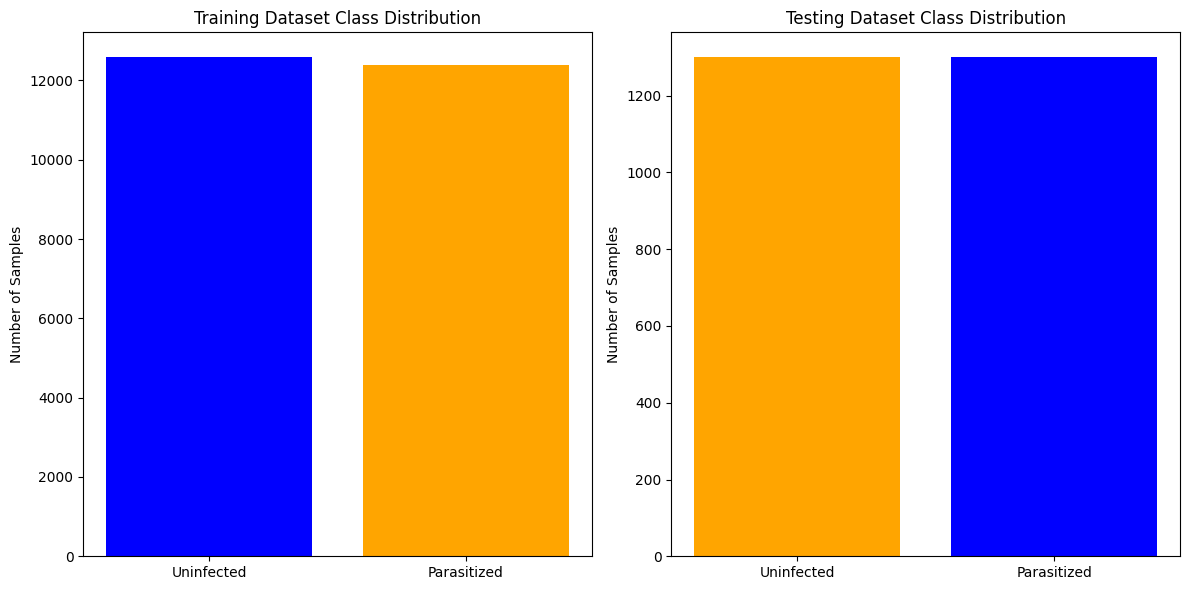

In [56]:
# Count the number of samples for each class in the training dataset
train_labels = [label.numpy()[0] for _, label in train_dataset_norm]
train_label_counts = Counter(train_labels)

# Count the number of samples for each class in the testing dataset
test_labels = [label.numpy()[0] for _, label in test_dataset_norm]
test_label_counts = Counter(test_labels)

# Plot the counts
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training dataset
ax[0].bar(train_label_counts.keys(), train_label_counts.values(), color=['blue', 'orange'])
ax[0].set_title("Training Dataset Class Distribution")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Uninfected', 'Parasitized'])
ax[0].set_ylabel("Number of Samples")

# Testing dataset
ax[1].bar(test_label_counts.keys(), test_label_counts.values(), color=['blue', 'orange'])
ax[1].set_title("Testing Dataset Class Distribution")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Uninfected', 'Parasitized'])
ax[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()


####<b> Observations and insights: _____

From the plot, we can see the dataset is well balanced.

### <b>Data Exploration</b>
Let's visualize the images from the train data

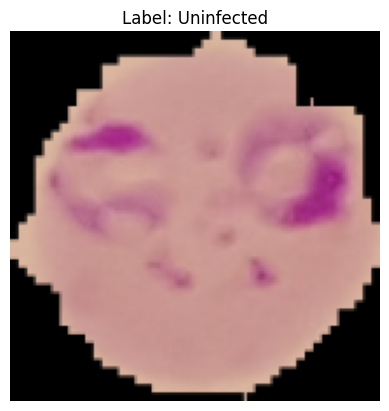

In [57]:
# Visualize one of the training images
for image, label in train_dataset_norm.take(1):
    plt.imshow(image.numpy())
    plt.title(f"Label: {'Parasitized' if label.numpy()[0] == 1.0 else 'Uninfected'}")
    plt.axis('off')
    plt.show()

### Observations and insights:

The image has been cropped to only show 1 whole blood cell. This should remove noise in the data but may cause the model to overfit, because the training and test data may be cleaner than real-world data.


###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

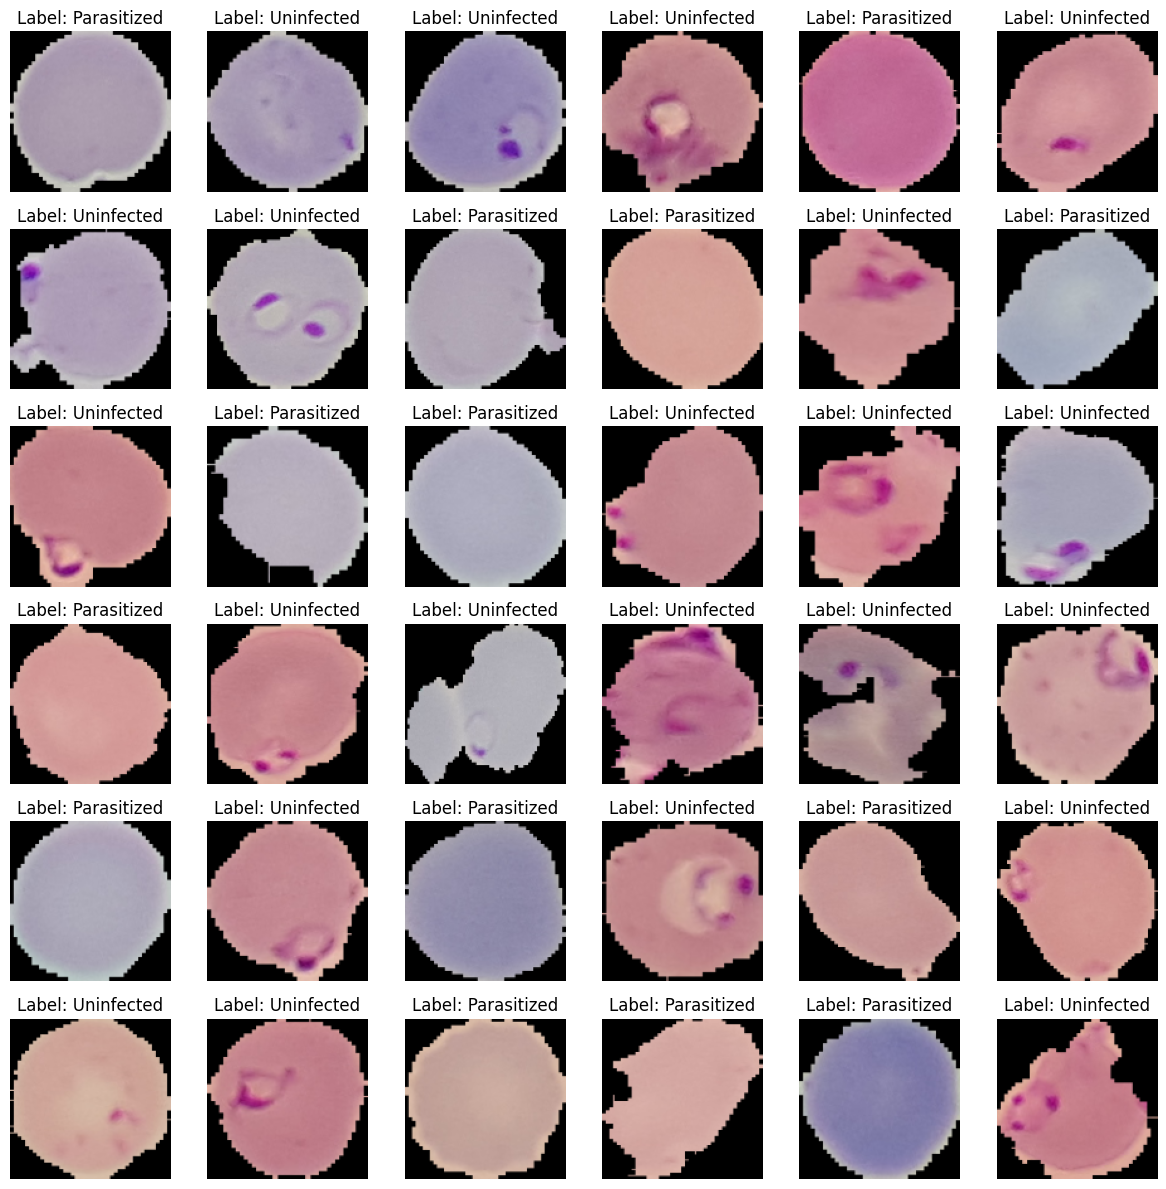

In [58]:
# Visualize 36 images from the training dataset in a grid
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_dataset_norm.take(36)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {'Parasitized' if label.numpy()[0] == 1.0 else 'Uninfected'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

####<b>Observations and insights:

###<b> Plotting the mean images for parasitized and uninfected

In [59]:
# split the dataset into parasitized and uninfected images
parasitized_images = [image.numpy() for image, label in train_dataset_norm if label.numpy()[0] == 1.0]
uninfected_images = [image.numpy() for image, label in train_dataset_norm if label.numpy()[0] == 0.0]


# Compute the mean image
mean_parasitized_image = np.mean(parasitized_images, axis=0)
mean_uninfected_image = np.mean(uninfected_images, axis=0)

print("Mean parasitized image shape:", mean_parasitized_image.shape)
print("Mean image shape:", mean_parasitized_image.shape)



Mean parasitized image shape: (128, 128, 3)
Mean image shape: (128, 128, 3)


<b> Mean image for parasitized

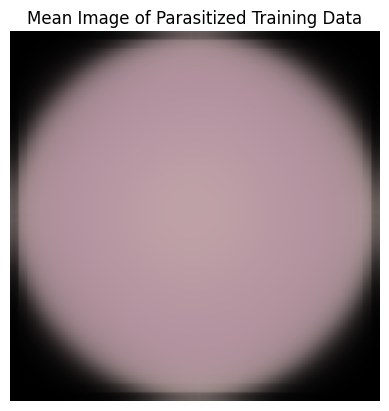

In [60]:
# Plot the mean image
plt.imshow(mean_parasitized_image)
plt.title("Mean Image of Parasitized Training Data")
plt.axis('off')
plt.show()

<b> Mean image for uninfected

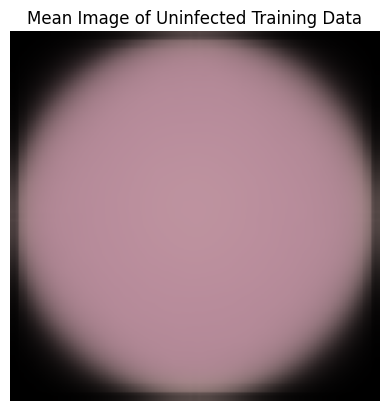

In [61]:
# plot the mean image of uninfected training data
plt.imshow(mean_uninfected_image)
plt.title("Mean Image of Uninfected Training Data")
plt.axis('off')
plt.show()

### Observations and insights: 

Very similar for uninfected and parasitized, suggesting that there is no overall pattern in the images from each class to suggest if a blood cell is infected or not.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

HSV Image Shape: (128, 128, 3)
Label: tf.Tensor([0.], shape=(1,), dtype=float32)


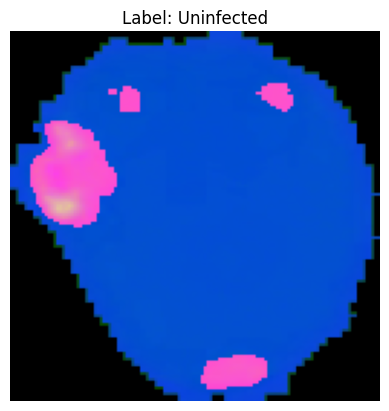

In [62]:
# Function to convert RGB images to HSV
def convert_to_hsv(image, label):
    hsv_image = tensorflow.image.rgb_to_hsv(image)  # Convert RGB to HSV
    return hsv_image, label

# Apply the conversion to the training dataset
train_dataset_hsv = train_dataset_norm.map(convert_to_hsv)


# func to plot hsv image
def plot_hsv_image(hsv_image, label):
    plt.imshow(hsv_image.numpy(), cmap='hsv')
    plt.title(f"Label: {'Parasitized' if label.numpy()[0] == 1.0 else 'Uninfected'}")
    plt.axis('off')
    plt.show()

# Inspect a sample from the HSV dataset
for hsv_image, label in train_dataset_hsv.take(1):
    print("HSV Image Shape:", hsv_image.shape)
    print("Label:", label)
    plot_hsv_image(hsv_image, label)


###<b> Converting the test data

HSV Image Shape: (128, 128, 3)
Label: tf.Tensor([1.], shape=(1,), dtype=float32)


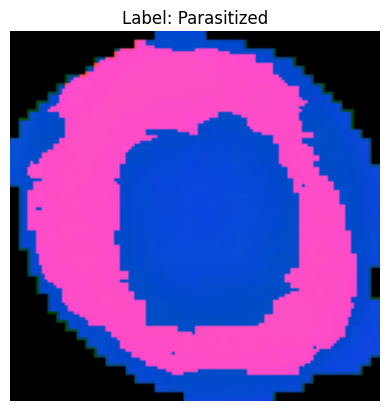

In [63]:
# Apply the conversion to the testing dataset
test_dataset_hsv = test_dataset_norm.map(convert_to_hsv)

# Inspect a sample from the HSV dataset
for hsv_image, label in test_dataset_hsv.take(1):
    print("HSV Image Shape:", hsv_image.shape)
    print("Label:", label)
    plot_hsv_image(hsv_image, label)

####<b>Observations and insights:

The images appear very different after converting to HSV

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

###<b> Gaussian Blurring on test data

####**Observations and insights: _____**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [64]:
from keras.models import Sequential
# layers for simple NN
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping

####<B>One Hot Encoding the train and test labels

In [65]:
# no need to one-hot encode the labels for binary classification

In [66]:
import random

# set seed for reproducibility
def setSeed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    tensorflow.random.set_seed(seed)

setSeed()

###<b> Building the model

In [67]:
NN_model_1 = Sequential()
# Flatten the input images
NN_model_1.add(Flatten(input_shape=(128, 128, 3)))
# Add a hidden layer with 1024 neurons and ReLU activation
NN_model_1.add(Dense(1024, activation='relu'))
# Add a dropout layer to reduce overfitting
NN_model_1.add(Dropout(0.5))
# Add another hidden layer with 512 neurons and ReLU activation
NN_model_1.add(Dense(512, activation='relu'))
# Add a dropout layer to reduce overfitting
NN_model_1.add(Dropout(0.5))
# Add a hidden layer with 128 neurons and ReLU activation
NN_model_1.add(Dense(128, activation='relu'))
# Add a dropout layer to reduce overfitting
NN_model_1.add(Dropout(0.5))
# Add the output layer with 1 neuron and sigmoid activation
NN_model_1.add(Dense(1, activation='sigmoid'))


/Users/rowandauria/Documents/GitHub/MIT Course Assignments/MIT ADSP Capstone Project/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###<b> Compiling the model

In [68]:
# Compile the model
NN_model_1.compile(optimizer=Adam(learning_rate=0.001),
                   loss=BinaryCrossentropy(),
                   metrics=[BinaryAccuracy()])
# Print the model summary
NN_model_1.summary()
# Train the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,923,265 (194.26 MB)

 Trainable params: 50,923,265 (194.26 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks 

In [69]:
# adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [70]:
train_dataset_norm_batch = train_dataset_norm.batch(32)
test_dataset_norm_batch = test_dataset_norm.batch(32)
print(train_dataset_norm_batch.cardinality())

tf.Tensor(780, shape=(), dtype=int64)


<b> Fit and train our Model

In [71]:
history_1 = NN_model_1.fit(train_dataset_norm_batch,
                          epochs=10,
                          batch_size=32,
                          validation_data=test_dataset_norm_batch,
                          callbacks=[early_stopping]
                        )

Epoch 1/10


2025-04-05 22:59:45.957386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


780/780 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - binary_accuracy: 0.5033 - loss: 622.8927 - val_binary_accuracy: 0.5000 - val_loss: 9.1650
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - binary_accuracy: 0.5033 - loss: 24.2887 - val_binary_accuracy: 0.5000 - val_loss: 1.3173
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - binary_accuracy: 0.5064 - loss: 19.8920 - val_binary_accuracy: 0.5000 - val_loss: 22.3743
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 702s 901ms/step - binary_accuracy: 0.5059 - loss: 21.1056 - val_binary_accuracy: 0.5000 - val_loss: 23.0845
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 3163s 4s/step - binary_accuracy: 0.5003 - loss: 26.5163 - val_binary_accuracy: 0.5000 - val_loss: 4.5936
Epoch 6/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 3422s 4s/step - binary_accuracy: 0.5020 - loss: 21.2600 - val_binary_accuracy: 0.5000 - val_loss: 8.6632
Epoch 7/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 8610s 11s/step - binary_accuracy: 0.5075 - loss: 25.9109 - val_binary_accuracy: 0.5000 - val_los

###<b> Evaluating the model on test data

<b> Plotting the confusion matrix

<b>Plotting the train and validation curves

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


###<b> Building the Model

###<b> Compiling the model

<b> Using Callbacks

<b>Fit and Train the model

###<b> Evaluating the model

<b> Plotting the confusion matrix

<b> Plotting the train and the validation curves

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

###<b> Building the Model

###<b>Compiling the model

<b> Using callbacks

<b>Fit and train the model

<b>Plotting the train and validation accuracy

###<b>Evaluating the model

####<b>Observations and insights: ____

<b> Generate the classification report and confusion matrix 

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

###<b> Use image data generator

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

####<b>Observations and insights: ____

###<b>Building the Model

<b>Using Callbacks

<b> Fit and Train the model

###<B>Evaluating the model

<b>Plot the train and validation accuracy

<B>Plotting the classification report and confusion matrix

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

###<b>Compiling the model

<b> using callbacks

<b>Fit and Train the model

<b>Plot the train and validation accuracy

###**Observations and insights: _____**

*   What can be observed from the validation and train curves?

###<b> Evaluating the model

<b>Plotting the classification report and confusion matrix

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


####<b> Observations and Conclusions drawn from the final model: _____



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?